Major League Baseball: Path to the Playoffs

Fans of the small budget East Division MLB teams, like the Baltimore Orioles, claim that their team has an unfair disadvantage in making it to the playoffs. They say that they have a harder time beating the highly budgeted, highly popular New York Yankees and Boston Red Sox, and that small budget teams in other leagues don't face that difficulty.  

Research Question: Determine if there is a statistically significant difference between MLB divisions in the difficulty to make it to the playoffs.

In [78]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy.contrasts import Treatment

In [31]:
#Data: 
#Accessed at http://www.espn.com/mlb/standings/_/ on March 2, 2018

mlb = pd.read_csv('/Users/ward60/Documents/mlb.txt', sep="\s+")
mlb = mlb[["W", "DIFF", "DIV"]]
mlb

,W,DIFF,DIV
0,93,117,East
1,91,198,East
2,80,-10,East
3,76,-91,East
4,75,-98,East
5,102,254,Central
6,85,27,Central
7,80,-89,Central
8,67,-114,Central
9,64,-159,Central


In [35]:
#EDA
#Summary Statistics for Wins and Run Differential
grouped = mlb.groupby('DIV')
print(grouped.mean())
print(grouped.std())


            W  DIFF
DIV                
Central  79.6 -16.2
East     83.0  23.2
West     82.4  14.2
                 W        DIFF
DIV                           
Central  15.274161  165.929804
East      8.455767  130.563012
West     10.549882  106.947183


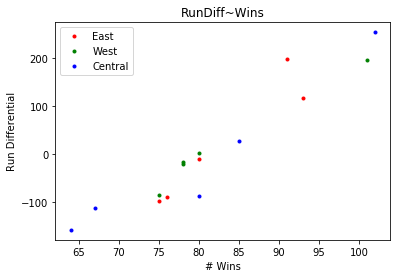

In [45]:
#Scatterplot of RunDiff~Wins with each division in it's own color
east = mlb[mlb["DIV"]=="East"]
west = mlb[mlb["DIV"]=="West"]
central = mlb[mlb["DIV"]=="Central"]

plt.plot(east["W"], east['DIFF'], ".", color='r', label="East")
plt.plot(west["W"], west['DIFF'], ".", color='g', label="West")
plt.plot(central["W"], central['DIFF'], ".", color='b', label="Central")
plt.xlabel("# Wins")
plt.ylabel("Run Differential")
plt.title("RunDiff~Wins")
plt.legend(loc='best')

In [79]:
#Fit the Model

fitted = smf.ols('W ~ C(DIV, Treatment) + DIFF', data=mlb).fit()
fitted.summary()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     36.05
Date:                Wed, 01 Aug 2018   Prob (F-statistic):           5.52e-06
Time:                        17:17:22   Log-Likelihood:                -38.880
No. Observations:                  15   AIC:                             85.76
Df Residuals:                      11   BIC:                             88.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    80.9289      1.693     47.809      0.000      77.203      84.655
C(DIV, Treatment)[T.East]     0.1680      2.408      0.070      0.946      -5.131       5.467
C(DIV, Treatment)[T.West]     0.3063      2.399      0.128      0.901      -4.974       5.587
DIFF                          0.0820      0.008     10.288      0.000       0.064       0.100
==============================================================================
Omnibus:                        0.109   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.162
Skew:                          -0.142   Prob(JB):                        0.922
Kurtosis:                       2.578   Cond. No.                         417.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated regression coefficient for this model means that if you hold the division constant, for every
run a team earns or every run a team prevents their opponent from getting, the team will win an average of 0.082
more games. 

Really there are 3 levels of divison, and therefore, 3 models based on which division we're considering.  

If DIV is East: Wins = Beta0 + beta1*0 + beta2*0 + beta3* RunDiff 

Simplifies =>  Wins = (Beta0) + beta3 *RunDiff

If DIV is Central: Wins = Beta0 + Beta1 * 1 + Beta2*0 + Beta3*RunDiff

Simplifies    =>  Wins = (Beta0 + Beta1) + Beta3*RunDiff

If DIV is West: Wins = Beta0 + Beta1*0 + Beta2*1 + Beta3*RunDiff

Simplifies =>  Wins =(Beta0 + Beta2) + Beta3 * RunDiff

Model for wins.hat:

 If East,           Wins = 81.1 + 0.08*Run.Diff
 
 If Central,       Wins = (81.1 + (-0.16)) + 0.08*Run.Diff
 
 If West,        Wins = (81.1 + 0.13) + 0.08*Run.Diff

In [66]:
#Simple definition that allow us to plot line based on slope and intercept in the specified color
def abline(slope, intercept, col="black"):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=col)

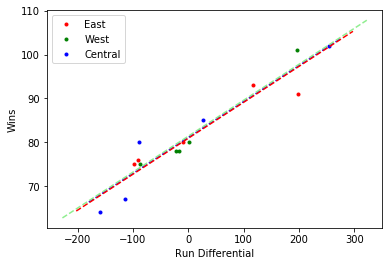

In [74]:
#plot showing the three predicted models
plt.plot(east['DIFF'], east["W"],  ".", color='r', label="East")
plt.plot(west['DIFF'], west["W"],  ".", color='g', label="West")
plt.plot(central['DIFF'], central["W"],  ".", color='b', label="Central")
abline(0.082029, 81.096918, 'blue')
abline(0.082029, 81.096918-0.168041, 'red')
abline(0.082029, 81.096918+0.306306, "lightgreen")
plt.xlabel("Run Differential")
plt.ylabel('Wins')
plt.legend(loc="best")
plt.show()

Test the hypothesis

H0: no difference between divisions after adjusting for run.diff

In [80]:
noeffect = smf.ols('W ~ DIFF', data=mlb).fit()
table = sm.stats.anova_lm(noeffect, fitted, typ=1) # Type 1 bc we are comparing multiple models
print(table)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0      13.0  156.915600      0.0       NaN       NaN       NaN
1      11.0  156.682928      2.0  0.232672  0.008167  0.991872


/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The test statistic from the anova test is 0.9919. We can therefore conclude that there is no statistically significant difference between the divisions in paths to the playoffs